# HSLS Preproccessing

What I do in this file 
* Pkl files without imputation
* Pkl files with imputation
* Pkl files with Teacher variables

New: All pkl files include 8th grade past performance

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error

import sys
sys.path.append("../../../core")
#from preprocessing import *


### Set Pandas options to display all rows and columns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)
from captum.attr import IntegratedGradients

### Supress warnings
import warnings; warnings.simplefilter('ignore')


In [17]:
student_pets = pd.read_csv("data/hsls_17_student_pets_sr_v1_0.csv")
school = pd.read_csv("data/hsls_09_school_v1_0.csv")

In [5]:
student_pets.shape

(23503, 9614)

In [6]:
school.shape

(944, 687)

In [18]:
student_vars = ['X1SEX', 'X1RACE', 'X1HHNUMBER', 'X1FAMINCOME','X1PAR1EDU', 'X1PAR2EDU', 'X1PAR1OCC2', 'X1PAR2OCC2',
                'X1MTHID', 'X1MTHUTI', 'X1MTHEFF', 'X1MTHINT',
                'S1LANG1ST', 'S1TEPOPULAR', 'S1TEMAKEFUN', 'S1MTHCOMP', 'S1SCICOMP',
                'S1MTCHRESPCT', 'S1MTCHFAIR', 'S1MTCHINTRST', 'S1MTCHEASY', 'S1MTCHVALUES', 'S1MTCHCONF',
                'S1APCALC', 'S1IBCALC']

# P1ELLNOW, P1USBORN9, P1USYR9 is majority non-respondents
parent_vars = ['P1REPEATGRD', 'P1ELLEVER',
               'P1MARSTAT', 'P1YRBORN1', 'P1YRBORN2', 'X1PAR1RACE', 'X1PAR2RACE', 'P1USBORN1', 'P1USBORN2', 
               'X1PAR1EDU', 'X1PAR2EDU', 'X1PAR1OCC2', 'X1PAR2OCC2',
               'P1JOBNOW1', 'P2JOBNOW1', 'P1JOBONET1_STEM1', 'P1JOBONET2_STEM1',
               'X1PARRESP', 'X1P1RELATION', 'P1HHTIME', 'P1EDUASPIRE', 'P1EDUEXPECT',
               'P1MTHHWEFF', 'P1SCIHWEFF', 'P1ENGHWEFF', 'P1MTHCOMP', 'P1SCICOMP', 'P1ENGCOMP',
               'P1MUSEUM', 'P1COMPUTER','P1FIXED', 'P1SCIFAIR', 'P1SCIPROJ', 'P1STEMDISC', 'P1CAMPMS', 'P1CAMPOTH',
               'P1NOOUTSCH', 'P1NOACT']

teacher_vars = ['M1SEX']

teacher_vars2 = ['M1HIDEG', 'M1HIMAJ2', 'M1HIDEGYR', 'M1BASCHED', 'M1HIDEGSCHED',
                'M1ALGEBRA', 'M1APPLIEDMTH', 'M1CALCULUS', 'M1DISCRETE', 'M1GEOMETRY', 'M1NUMBERTH', 'M1STATS', 'M1NOMATH',
                'M1MATHJOB', 'M1ALTCERT', 'M1CERTTYPE', 'M1MTHYRS912',
                'X1TMRACE', 'X1TMCERT', 'X1TMCOMM', 'X1TMEFF', 'X1TMEXP', 'X1TMPRINC', 'X1TMRESP',
                'M1ENGCOMP', 'M1MTHCOMP', 'M1SCICOMP',
                'M1RESOURCES', 'M1RATIO', 'M1FACILITIES', 'M1TIMPROVE', 'M1TSETSTDS', 'M1TALLLEARN', 'M1TSELFDEV']
# 'M1SHRIDEAS', 'M1WORKSHOP', 'M1SHRSTWRK', 'M1SHRLESSONS', 'M1SHRBELIEFS', 'M1SHRMTHDS', 'M1SHRELL', 'M1SHRAPPRCH', 'M1SHRCONTENT', 'M1EFFECTIVE', 'M1MENTOR', 'M1CHAIR'
# 'M1FAMILY', 'M1DISCIPLINE', 'M1STUACHIEVE', 'M1PARENT', 'M1RETAIN', 'M1REDIRECT', 'M1GETTHRU', 'M1HOMEFX'


grade_vars = ['X1TXMSCR', 'X2TXMSCR', 'S1M8GRADE']
target = 'X1TXMSCR'

all_vars = grade_vars+student_vars+parent_vars+teacher_vars

## Preprocessing with Student, Parent Variables

### No imputation, Dropping all missing values

In [19]:
## Selecting relevant features ##
df = student_pets[all_vars]
print(df.shape)

def process_hsls_data(df):
    """
    Processes the HSLS dataset, scales numerical features, creates binary variables, and prepares the data for analysis.
    Args:
        df (pd.DataFrame): The cleaned HSLS dataset.
    Returns:
        df_new (pd.DataFrame): The processed and transformed HSLS dataset.
    """
    # 1. Drop missing or invalid values based on key features
    df = df[df['X1TXMSCR'] >= 0]  # Keep rows where 'X1TXMSCR' is non-negative
    df = df[(df > -7).all(axis=1)]  # Remove rows with values less than -7 across all columns
    print(df.shape)
    #print(df['X1RACE'].value_counts())

    # Only keep rows where 'X1RACE' is 2 (Black) or 3 (Hispanic)
    df = df[(df['X1RACE'] == 2) | (df['X1RACE'] == 3)]
    print(df.shape)
    
    # 3. Separate numerical features for scaling and categorical features to retain their original values
    numerical_features = ['X1TXMSCR', 'X2TXMSCR', 'X1HHNUMBER', 'X1FAMINCOME']  # List of numerical features to scale
    categorical_features = ['X1SEX', 'X1RACE']  # Categorical features to keep unchanged

    # 4. Scale only the numerical features using MinMaxScaler
    scaler = MinMaxScaler()
    df_scaled_numerical = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features, index=df.index)

    # 5. Combine scaled numerical features with unchanged categorical features
    df_scaled = pd.concat([df_scaled_numerical, df[categorical_features]], axis=1)

    # 3. Rename columns for better readability
    df_scaled.rename(columns={'X1SEX': 'studentgender', 'X1RACE': 'studentrace'}, inplace=True)

    # 4. Create binary variables based on certain criteria
    df_scaled['grade9thbin'] = (df_scaled['X1TXMSCR'] > df_scaled['X1TXMSCR'].median()).astype(int)
    df_scaled['grade12thbin'] = (df_scaled['X2TXMSCR'] > df_scaled['X2TXMSCR'].median()).astype(int)

    # Add the binary columns to a tracking list if needed
    grade_vars = ['grade9thbin', 'grade12thbin']

    # 6. Select relevant columns for feature preparation
    # Specify the features and target variables
    features_all = ['X1TXMSCR', 'X2TXMSCR', 'studentgender', 'studentrace', 'X1HHNUMBER', 'X1FAMINCOME', 'grade9thbin', 'grade12thbin']
    target = 'X1TXMSCR'  # Using 9th grade test score as the target for this example

    # 8. Prepare the full feature set (X_all) and the target variable (y)
    X_all = df_scaled[features_all]
    print(X_all.shape)
    y = df_scaled[target]

    # 9. Prepare the feature set excluding specific sensitive attributes (e.g., 'studentgender' and 'studentrace')
    features_without_sensitive = ['X1TXMSCR', 'X2TXMSCR', 'X1HHNUMBER', 'X1FAMINCOME', 'grade9thbin', 'grade12thbin']  # Exclude 'studentgender' and 'studentrace'
    X_without_sensitive = df_scaled[features_without_sensitive]

    return X_all, X_without_sensitive, y

# Use the function to process the HSLS dataset (assuming `df` is already loaded)
X_all, X_without_sensitive, y = process_hsls_data(df)
print(X_all['studentgender'])

# Display a summary of the processed data
print("Processed Data Summary:")
print(X_all.describe())

(23503, 67)
(5425, 67)
X1RACE
8    3625
5     643
6     451
2     360
3     291
7      24
1      18
4      13
Name: count, dtype: int64
(651, 67)
(651, 8)
23       2
35       2
50       1
64       1
89       2
94       1
99       2
104      1
118      2
187      1
210      2
233      1
264      2
273      1
388      1
409      1
412      1
419      2
542      1
567      2
569      1
582      2
605      1
672      2
681      1
699      1
715      2
734      1
749      2
762      1
765      2
766      2
851      2
862      1
890      2
901      2
922      1
924      1
1031     2
1035     2
1044     2
1119     1
1201     1
1225     1
1237     1
1293     1
1330     1
1333     2
1335     2
1380     2
1392     2
1399     1
1427     2
1466     2
1467     2
1476     2
1514     2
1589     2
1677     1
1679     1
1680     2
1710     1
1732     2
1734     1
1759     1
1770     2
1835     2
1914     2
2089     1
2113     2
2120     1
2143     2
2148     1
2200     2
2290     1
2325     1
2348     

In [20]:
df_new['S1M8GRADE'].hist(bins=20)

NameError: name 'df_new' is not defined

In [21]:
# Define a neural network model with batch normalization and dropout
class DeeperNNWithBatchNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, dropout_prob=0.5):
        super(DeeperNNWithBatchNorm, self).__init__()
        # Define layers with batch normalization and dropout
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)

        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_prob)

        self.fc4 = nn.Linear(hidden_dim3, 1)  # Output layer for regression task

    def forward(self, x):
        # Forward pass through layers with batch normalization, activation, and dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

# Function to train the neural network model on HSLS data
def train_neural_network_model(X_train, y_train, input_dim, lr=0.001, epochs=1000, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64, dropout_prob=0.5):
    # Initialize the neural network model with specified dimensions and dropout
    model = DeeperNNWithBatchNorm(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, dropout_prob)
    criterion = nn.MSELoss()  # Mean squared error for regression
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer for better convergence
    
    # Convert training data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(pd.to_numeric(y_train).values, dtype=torch.float32).view(-1, 1)
    
    # Store the loss values for visualization
    loss_values = []
    
    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        optimizer.zero_grad()  # Zero gradients
        outputs = model(X_train_tensor)  # Forward pass
        loss = criterion(outputs, y_train_tensor)  # Compute loss
        loss.backward()  # Backpropagate loss
        optimizer.step()  # Update weights
        
        # Save loss value for each epoch
        loss_values.append(loss.item())

        # Optional: Print the loss every 100 epochs to monitor progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    # Plot the loss values
    plt.plot(range(epochs), loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

    return model

In [22]:
def predict_model(model, X):
    model.eval()
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(X_tensor).squeeze()
    return predictions.numpy()

# Function to evaluate the neural network regression model
def evaluate_model_regression(model, X_train, X_test, y_train, y_test, model_name):
    # Predict on training and test data
    y_train_pred = predict_model(model, X_train)
    y_test_pred = predict_model(model, X_test)

    # Calculate regression metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Plot predictions vs true values for test data
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Predictions vs True Values - Test Data ({model_name})')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line of perfect prediction
    plt.show()

    # Print regression metrics
    print(f"{model_name} - Training MSE: {train_mse:.4f}")
    print(f"{model_name} - Test MSE: {test_mse:.4f}")

In [23]:
# Function to train and evaluate models using the HSLS dataset
def train_and_evaluate_model():
    # Step 1: Process and prepare the HSLS data (assuming `df` is already loaded and cleaned)
    X_all, X_without_sensitive, y = process_hsls_data(df)

    # Step 2: Split the data into training and testing sets for both feature sets
    X_train_hp, X_test_hp, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)
    X_train_h0, X_test_h0 = train_test_split(X_without_sensitive, test_size=0.3, random_state=42)

    print("Running regression task")

    # Step 3: Train and evaluate model using all features (HP)
    print("Training and evaluating model with all features (HP)...")
    model_hp = train_neural_network_model(X_train_hp, y_train, X_train_hp.shape[1], lr=0.001, epochs=1000)
    evaluate_model_regression(model_hp, X_train_hp, X_test_hp, y_train, y_test, "h_p")

    # Step 4: Train and evaluate model excluding sensitive attributes (H0)
    print("\nTraining and evaluating model excluding sensitive attributes (H0)...")
    model_h0 = train_neural_network_model(X_train_h0, y_train, X_train_h0.shape[1], lr=0.001, epochs=1000)
    evaluate_model_regression(model_h0, X_train_h0, X_test_h0, y_train, y_test, "h_0")

    # Step 5: Return the necessary objects
    return X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0

In [24]:
def create_gender_race_filters(X_test):
    """
    Create filters for the four groups based on combinations of gender and race.
    Example groups: Female + White, Female + Black, Male + White, Male + Black.
    """
    filters = {}

    # Female + White
    filters['Female + Hispanic'] = (X_test['studentgender'] == 2) & (X_test['studentrace'] == 3)
    
    # Female + Black
    filters['Female + Black'] = (X_test['studentgender'] == 2) & (X_test['studentrace'] == 2)
    
    # Male + White
    filters['Male + Hispanic'] = (X_test['studentgender'] == 1) & (X_test['studentrace'] == 3)
    
    # Male + Black
    filters['Male + Black'] = (X_test['studentgender'] == 1) & (X_test['studentrace'] == 2)

    return filters


def evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness=False):
    """
    Evaluate predictions for a specific group using a custom cost function.
    Filter predictions and true values using group indices (e.g., gender + race).
    """
    y_group_pred = y_preds[group_indices]
    y_group_val = y_val[group_indices]

    # Compute element-wise loss using the custom cost function
    individual_losses = np.array([cost_function(true, pred) for true, pred in zip(y_group_val, y_group_pred)])
    if comprehensiveness:
        individual_losses = 1 / individual_losses

    total_loss = np.mean(individual_losses)
    
    return total_loss, y_group_pred, y_group_val


def evaluate_model_by_combined_groups(y_preds, y_val, filters, cost_function, comprehensiveness=False):
    """
    Evaluate predictions based on combined filters for gender and race.
    """
    group_losses = {}
    group_results = {}

    for group_name, group_indices in filters.items():
        group_loss, group_preds, group_true = evaluate_model_for_group(y_preds, y_val, group_indices, cost_function, comprehensiveness)
        group_losses[group_name] = group_loss
        group_results[group_name] = (group_preds, group_true)

    return group_losses, group_results


def compare_models_by_gender_race_filters(y_preds_hp, y_preds_h0, X_test, y_val_hp, y_val_h0, cost_function, comprehensiveness=False):
    """
    Compare models' predictions dynamically by gender and race using filters.
    """
    # Create filters for gender and race groups
    filters = create_gender_race_filters(X_test)

    # Evaluate total losses for both models using only the subjects with race = 1 or 2
    total_loss_hp = np.mean([cost_function(true, pred) for true, pred in zip(y_val_hp, y_preds_hp)])
    total_loss_h0 = np.mean([cost_function(true, pred) for true, pred in zip(y_val_h0, y_preds_h0)])
    
    if comprehensiveness:
        total_loss_hp = 1 / total_loss_hp
        total_loss_h0 = 1 / total_loss_h0

    # Evaluate model h_p by group
    group_losses_hp, group_results_hp = evaluate_model_by_combined_groups(y_preds_hp, y_val_hp, filters, cost_function, comprehensiveness)

    # Evaluate model h_0 by group
    group_losses_h0, group_results_h0 = evaluate_model_by_combined_groups(y_preds_h0, y_val_h0, filters, cost_function, comprehensiveness)

    # Print results and calculate differences
    for group_name in filters:
        loss_hp = group_losses_hp[group_name]
        loss_h0 = group_losses_h0[group_name]
        loss_diff = loss_h0 - loss_hp
        print(f"Group {group_name} - Model h_p: {loss_hp:.4f}, Model h_0: {loss_h0:.4f}, Loss difference: {loss_diff:.4f}")

    print(f"Total loss h_p: {total_loss_hp:.4f}")
    print(f"Total loss h_0: {total_loss_h0:.4f}")
    print(f"Total loss difference: {total_loss_h0 - total_loss_hp:.4f}")

    return group_losses_hp, group_losses_h0

In [25]:
def individual_loss_difference(y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title):
    """
    Compute the loss difference between y_preds_h0 and y_preds_hp on a per-individual basis for a given group (e.g., gender + race).
    """
    # Filter predictions and true values for the selected group
    y_preds_h0_filtered = y_preds_h0[group_indices]
    y_preds_hp_filtered = y_preds_hp[group_indices]
    y_vals_h0_filtered = y_val_h0[group_indices]
    y_vals_hp_filtered = y_val_hp[group_indices]

    if title == "Comprehensiveness":
        # Reciprocal the losses for comprehensiveness
        individual_diff = np.array([1 / cost_function(val_h0, pred_h0) - 1 / cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])
    else:
        # Compute individual element-wise losses using the custom cost function
        individual_diff = np.array([cost_function(val_h0, pred_h0) - cost_function(val_hp, pred_hp)
                                    for val_h0, val_hp, pred_h0, pred_hp in zip(y_vals_h0_filtered, y_vals_hp_filtered, y_preds_h0_filtered, y_preds_hp_filtered)])

    return individual_diff

def plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test, y_val_h0, y_val_hp, cost_function, title):
    """
    Generate histograms of the loss difference between two sets of predictions (h0 and hp) for multiple groups using a custom element-wise cost function.
    Displays standard deviation underneath each subplot.
    """
    # Create filters for the groups (assumes `create_gender_race_filters` is defined based on gender and race)
    filters = create_gender_race_filters(X_test)

    # Determine the number of rows and columns based on the number of groups for subplots
    num_filters = len(filters)
    num_cols = 2
    num_rows = int(np.ceil(num_filters / num_cols))

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    axes = axes.flatten()  # Flatten in case of multi-dimensional array

    for i, (group_name, group_indices) in enumerate(filters.items(), start=0):
        # Compute loss differences for each group
        group_loss_diff = individual_loss_difference(
            y_preds_h0, y_preds_hp, y_val_h0, y_val_hp, group_indices, cost_function, title
        )

        # Calculate standard deviation
        stddev = np.std(group_loss_diff)

        # Plot histogram for each group
        axes[i].hist(group_loss_diff, bins=30, alpha=0.7)
        axes[i].set_title(f'{cost_function.__name__} Difference Histogram for {group_name} ({title})')
        axes[i].set_xlabel('Difference in Loss')
        axes[i].set_ylabel('Frequency')

        # Add standard deviation as a text label under each subplot
        axes[i].text(0.5, -0.15, f'stddev: {stddev:.4f}', transform=axes[i].transAxes,
                     fontsize=12, ha='center', color='red')

    # Remove any unused subplots (if filters count is less than number of subplots)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [26]:
# For scalars
def squared_error(true_value, pred_value):
    return (true_value - pred_value) ** 2

def zero_one_loss(true_value, pred_prob):
    pred_label = 1 if pred_prob >= 0.5 else 0
    if 0 < true_value < 1:  # If the true value is a probability, convert to binary label, this is for the case of explainers
        true_value = 1 if true_value >= 0.5 else 0
    return 1 if true_value != pred_label else 0

def binary_cross_entropy_loss(true_value, pred_prob):
    epsilon = 1e-12
    pred_prob = np.clip(pred_prob, epsilon, 1. - epsilon)
    loss = -(true_value * np.log(pred_prob) + (1 - true_value) * np.log(1 - pred_prob))
    return loss

In [27]:
# Function to apply Integrated Gradients
def explain_with_ig(model, X_test):
    ig = IntegratedGradients(model)
    
    # Convert the test set to PyTorch tensor
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Compute attributions using Integrated Gradients
    attributions, delta = ig.attribute(X_test_tensor, return_convergence_delta=True)
    # Print the shape of attributions
    print("Shape of attributions:", attributions.shape)
    
    return attributions, delta

# Function to calculate comprehensiveness
def comprehensiveness(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)

    # Remove top_k important features
    for i in range(X_test_tensor.size(0)):
        top_features = top_attributions[i, :top_k]
        X_test_tensor[i, top_features] = 0
    
    # Re-run the model to get new predictions with removed features
    #print("X_test_tensor shape", X_test_tensor.shape)
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()

    return new_predictions

# Function to calculate(sufficiency)
def sufficiency(model, X_test, attributions, top_k):
    model.eval()
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    
    # Sort attributions by importance
    top_attributions = torch.argsort(attributions, descending=True)
    
    # Keep only top_k important features and zero out the rest
    for i in range(X_test_tensor.size(0)):
        mask = torch.zeros(X_test_tensor.size(1), dtype=torch.float32)
        top_features = top_attributions[i, :top_k]
        mask[top_features] = 1
        X_test_tensor[i] = X_test_tensor[i] * mask
    
    # Re-run the model to get new predictions with only important features
    with torch.no_grad():
        new_predictions = model(X_test_tensor).squeeze().numpy()
    
    return new_predictions


In [28]:
def plot_group_losses(ks, hp_comp_list, h0_comp_list, hp_suff_list, h0_suff_list, group_name, cost_function, row_index):
    """
    Helper function to plot comprehensiveness and sufficiency losses for a specific group.
    """
    plt.subplot(4, 2, row_index)
    plt.plot(ks, hp_comp_list, label=f'{group_name} h_p (Comp)', marker='o')
    plt.plot(ks, h0_comp_list, label=f'{group_name} h_0 (Comp)', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Comprehensiveness')
    plt.legend()

    plt.subplot(4, 2, row_index + 4)  # Sufficiency plots in lower half
    plt.plot(ks, hp_suff_list, label=f'{group_name} h_p (Suff)', marker='o')
    plt.plot(ks, h0_suff_list, label=f'{group_name} h_0 (Suff)', marker='o')
    plt.xlabel('Top r Features Removed')
    plt.ylabel(f'{cost_function.__name__} Loss')
    plt.title(f'{group_name} Sufficiency')
    plt.legend()

def plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, cost_function, ks):
    """
    Plot loss differences for comprehensiveness and sufficiency over the four groups (Female/Male + Good/Poor Health)
    for different top_k feature removal.
    """
    # Initialize dictionaries to store the results
    group_names = ['Female + Good Health', 'Female + Poor Health', 'Male + Good Health', 'Male + Poor Health']
    
    comp_lists_hp = {group: [] for group in group_names}
    comp_lists_h0 = {group: [] for group in group_names}
    suff_lists_hp = {group: [] for group in group_names}
    suff_lists_h0 = {group: [] for group in group_names}

    # Loop over different top_k values
    for top_k in ks:
        # Comprehensiveness and Sufficiency predictions
        comprehensiveness_preds_hp = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
        comprehensiveness_preds_h0 = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)
        sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
        sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

        # Filters for groups
        filters = create_gender_race_filters(X_test_hp)

        # Loop over groups and calculate losses
        for group_name, group_indices in filters.items():
            # Comprehensiveness
            group_hp_comp, group_h0_comp = compare_models_by_gender_race_filters(
                comprehensiveness_preds_hp, comprehensiveness_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function, comprehensiveness=True)
            
            # Sufficiency
            group_hp_suff, group_h0_suff = compare_models_by_gender_race_filters(
                sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, cost_function)
            
            # Store results
            comp_lists_hp[group_name].append(group_hp_comp[group_name])
            comp_lists_h0[group_name].append(group_h0_comp[group_name])
            suff_lists_hp[group_name].append(group_hp_suff[group_name])
            suff_lists_h0[group_name].append(group_h0_suff[group_name])

    # Plot comprehensiveness and sufficiency for each group
    plt.figure(figsize=(14, 12))
    
    for i, group_name in enumerate(group_names, start=1):
        plot_group_losses(ks, comp_lists_hp[group_name], comp_lists_h0[group_name],
                          suff_lists_hp[group_name], suff_lists_h0[group_name], group_name, cost_function, i)

    plt.tight_layout()
    plt.show()

(5425, 67)
X1RACE
8    3625
5     643
6     451
2     360
3     291
7      24
1      18
4      13
Name: count, dtype: int64
(651, 67)
(651, 8)
Running regression task
Training and evaluating model with all features (HP)...
Epoch [100/1000], Loss: 0.0458
Epoch [200/1000], Loss: 0.0222
Epoch [300/1000], Loss: 0.0155
Epoch [400/1000], Loss: 0.0129
Epoch [500/1000], Loss: 0.0108
Epoch [600/1000], Loss: 0.0090
Epoch [700/1000], Loss: 0.0079
Epoch [800/1000], Loss: 0.0066
Epoch [900/1000], Loss: 0.0062
Epoch [1000/1000], Loss: 0.0061


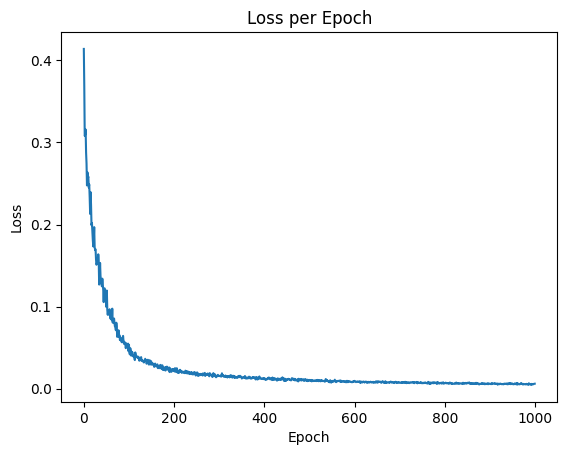

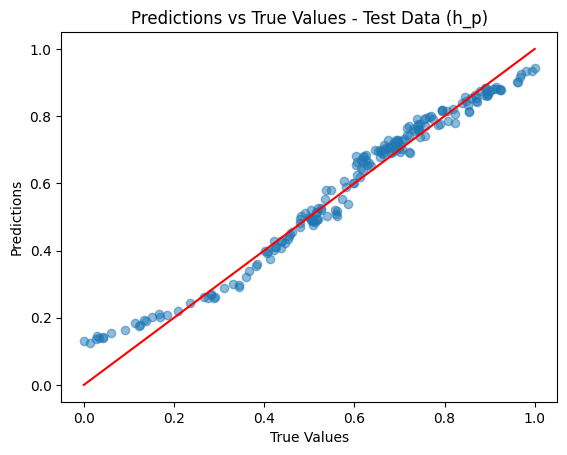

h_p - Training MSE: 0.0012
h_p - Test MSE: 0.0015

Training and evaluating model excluding sensitive attributes (H0)...
Epoch [100/1000], Loss: 0.0970
Epoch [200/1000], Loss: 0.0399
Epoch [300/1000], Loss: 0.0247
Epoch [400/1000], Loss: 0.0179
Epoch [500/1000], Loss: 0.0145
Epoch [600/1000], Loss: 0.0117
Epoch [700/1000], Loss: 0.0118
Epoch [800/1000], Loss: 0.0102
Epoch [900/1000], Loss: 0.0090
Epoch [1000/1000], Loss: 0.0069


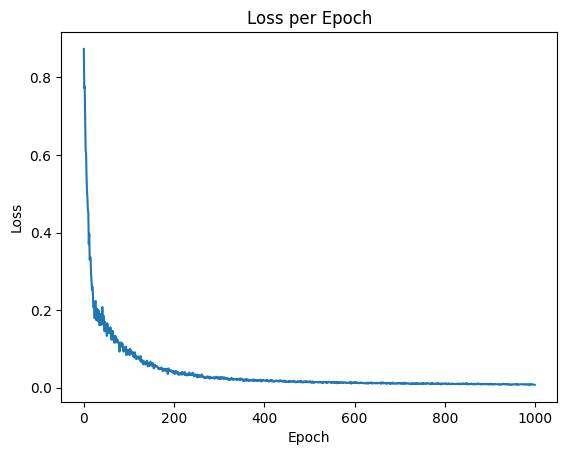

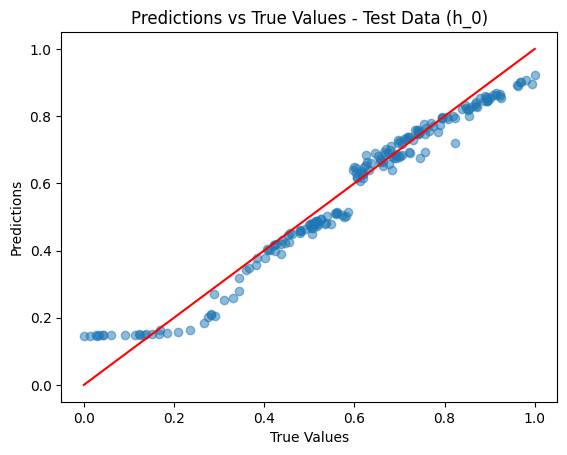

h_0 - Training MSE: 0.0018
h_0 - Test MSE: 0.0020


In [29]:
X_train_hp, X_test_hp, y_train, y_test, X_train_h0, X_test_h0, model_hp, model_h0 = train_and_evaluate_model()

For test data:
Number of individuals in 'Female + Hispanic':  36
Number of individuals in 'Female + Black':  46
Number of individuals in 'Male + Hispanic':  51
Number of individuals in 'Male + Black':  63
Group Female + Hispanic - Model h_p: 0.0012, Model h_0: 0.0009, Loss difference: -0.0003
Group Female + Black - Model h_p: 0.0011, Model h_0: 0.0015, Loss difference: 0.0004
Group Male + Hispanic - Model h_p: 0.0027, Model h_0: 0.0034, Loss difference: 0.0008
Group Male + Black - Model h_p: 0.0009, Model h_0: 0.0017, Loss difference: 0.0008
Total loss h_p: 0.0015
Total loss h_0: 0.0020
Total loss difference: 0.0005
For training data:
Number of individuals in 'Female + Hispanic':  102
Number of individuals in 'Female + Black':  135
Number of individuals in 'Male + Hispanic':  102
Number of individuals in 'Male + Black':  116
Group Female + Hispanic - Model h_p: 0.0012, Model h_0: 0.0019, Loss difference: 0.0008
Group Female + Black - Model h_p: 0.0012, Model h_0: 0.0017, Loss differenc

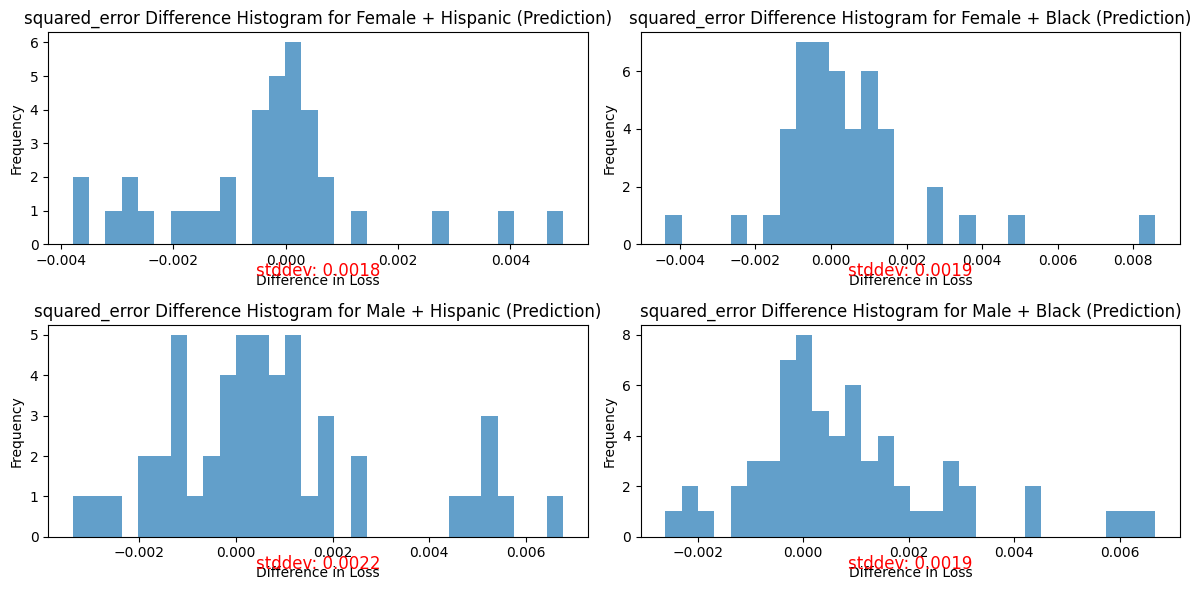

In [34]:
# Step 2: Generate predictions for both models (h_p and h_0)
y_preds_hp = predict_model(model_hp, X_test_hp)  # Using the model trained with all features (h_p)
y_preds_h0 = predict_model(model_h0, X_test_h0)  # Using the model trained excluding gender and race (h_0)

# Use the same true labels for both models
y_test_hp = y_test
y_test_h0 = y_test

# Step 3: Compare models by gender and race using regression cost function (mean squared error)
print("For test data:")
filters = create_gender_race_filters(X_test_hp)
print("Number of individuals in 'Female + Hispanic': ", (filters['Female + Hispanic']).sum())
print("Number of individuals in 'Female + Black': ", (filters['Female + Black']).sum())
print("Number of individuals in 'Male + Hispanic': ", (filters['Male + Hispanic']).sum())
print("Number of individuals in 'Male + Black': ", (filters['Male + Black']).sum())

# Compare model performance using the defined filters
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(
    y_preds_hp, y_preds_h0, X_test_hp, y_test_hp, y_test_h0, squared_error, comprehensiveness=False
)

print("For training data:")
# Generate predictions for training data
y_preds_hp_train = predict_model(model_hp, X_train_hp)
y_preds_h0_train = predict_model(model_h0, X_train_h0)

# Display number of individuals in each group (based on gender + race)
filters_train = create_gender_race_filters(X_train_hp)
print("Number of individuals in 'Female + Hispanic': ", (filters_train['Female + Hispanic']).sum())
print("Number of individuals in 'Female + Black': ", (filters_train['Female + Black']).sum())
print("Number of individuals in 'Male + Hispanic': ", (filters_train['Male + Hispanic']).sum())
print("Number of individuals in 'Male + Black': ", (filters_train['Male + Black']).sum())

# True labels for training data
y_train_hp = y_train
y_train_h0 = y_train

# Compare models for training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(
    y_preds_hp_train, y_preds_h0_train, X_train_hp, y_train_hp, y_train_h0, squared_error, comprehensiveness=False
)

# Step 4: Plot loss difference histograms for model predictions using mean squared error
plot_loss_difference_histogram(y_preds_h0, y_preds_hp, X_test_hp, y_test_h0, y_test_hp, squared_error, "Prediction")

In [35]:
# Step 5: Generate explanations with Integrated Gradients for test and training data
attributions_hp, _ = explain_with_ig(model_hp, X_test_hp)
attributions_h0, _ = explain_with_ig(model_h0, X_test_h0)

# Generate explanations for training data
attributions_hp_train, _ = explain_with_ig(model_hp, X_train_hp)
attributions_h0_train, _ = explain_with_ig(model_h0, X_train_h0)

Shape of attributions: torch.Size([196, 8])
Shape of attributions: torch.Size([196, 6])
Shape of attributions: torch.Size([455, 8])
Shape of attributions: torch.Size([455, 6])


For testing data explainer


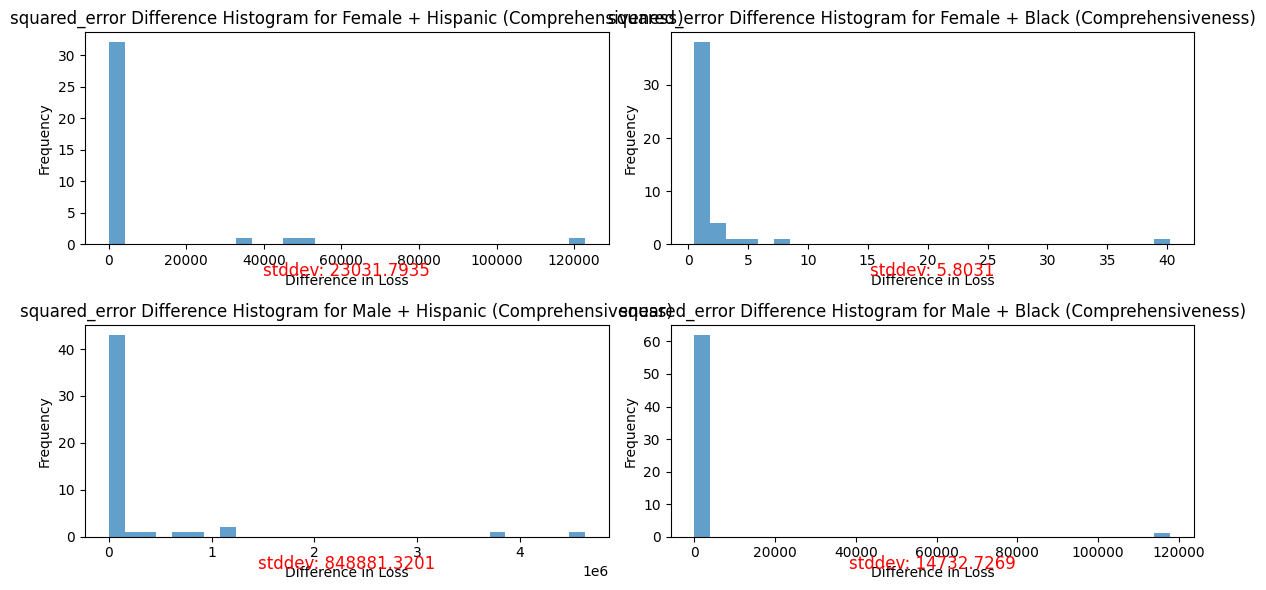

Group Female + Hispanic - Model h_p: 19.5172, Model h_0: 7286.9973, Loss difference: 7267.4801
Group Female + Black - Model h_p: 3.5778, Model h_0: 5.7995, Loss difference: 2.2217
Group Male + Hispanic - Model h_p: 125.1948, Model h_0: 257377.9056, Loss difference: 257252.7108
Group Male + Black - Model h_p: 7.5436, Model h_0: 1891.5811, Loss difference: 1884.0375
Total loss h_p: 2.8395
Total loss h_0: 4.2708
Total loss difference: 1.4313


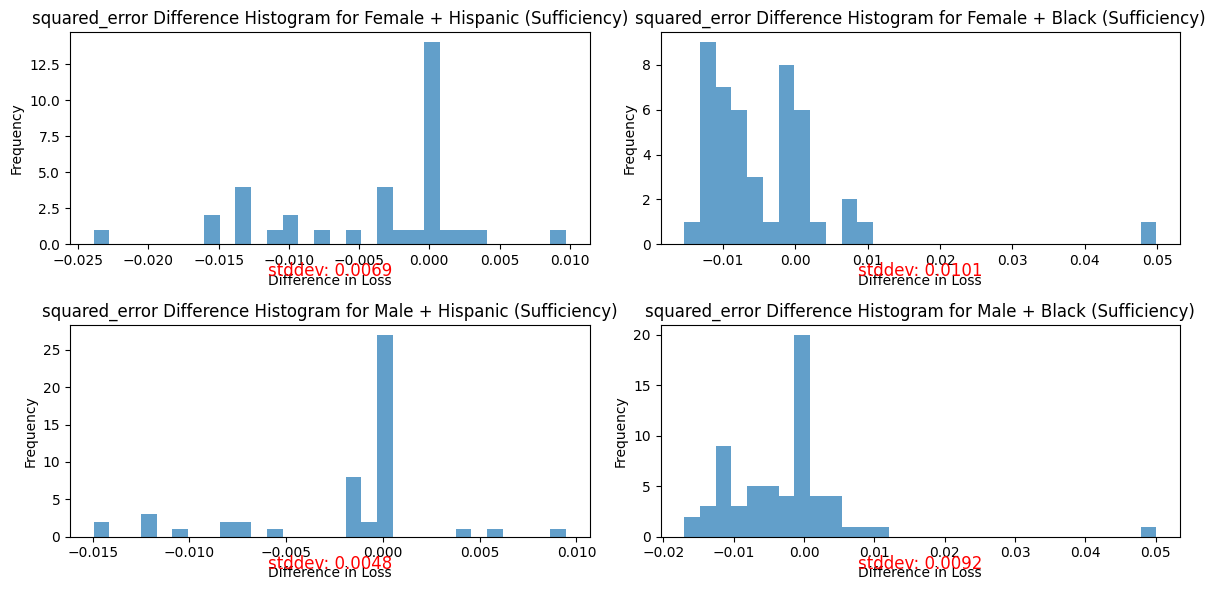

Group Female + Hispanic - Model h_p: 0.0068, Model h_0: 0.0026, Loss difference: -0.0042
Group Female + Black - Model h_p: 0.0111, Model h_0: 0.0069, Loss difference: -0.0042
Group Male + Hispanic - Model h_p: 0.0039, Model h_0: 0.0018, Loss difference: -0.0021
Group Male + Black - Model h_p: 0.0101, Model h_0: 0.0074, Loss difference: -0.0028
Total loss h_p: 0.0081
Total loss h_0: 0.0050
Total loss difference: -0.0032
For training data explainer
Group Female + Hispanic - Model h_p: 28.7951, Model h_0: 10469.7875, Loss difference: 10440.9924
Group Female + Black - Model h_p: 11.7302, Model h_0: 3230.5806, Loss difference: 3218.8504
Group Male + Hispanic - Model h_p: 38.5316, Model h_0: 20493.4143, Loss difference: 20454.8827
Group Male + Black - Model h_p: 14.0436, Model h_0: 10318.5289, Loss difference: 10304.4853
Total loss h_p: 3.2312
Total loss h_0: 4.8946
Total loss difference: 1.6634
Group Female + Hispanic - Model h_p: 0.0034, Model h_0: 0.0020, Loss difference: -0.0015
Group Fe

KeyError: 'Female + Hispanic'

In [37]:
top_k = 4  # Adjust the number of top features to remove

# Step 6: Analyze comprehensiveness for test data
print("For testing data explainer")
comprehensiveness_preds_hp_reg = comprehensiveness(model_hp, X_test_hp, attributions_hp, top_k)
comprehensiveness_preds_h0_reg = comprehensiveness(model_h0, X_test_h0, attributions_h0, top_k)

# Plot loss differences for comprehensiveness
plot_loss_difference_histogram(comprehensiveness_preds_h0_reg, comprehensiveness_preds_hp_reg, X_test_hp, y_preds_h0, y_preds_hp, squared_error, "Comprehensiveness")

# Compare models for comprehensiveness
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(comprehensiveness_preds_hp_reg, comprehensiveness_preds_h0_reg, X_test_hp, y_preds_hp, y_preds_h0, squared_error, comprehensiveness=True)

# Step 7: Analyze sufficiency for test data
sufficiency_preds_hp = sufficiency(model_hp, X_test_hp, attributions_hp, top_k)
sufficiency_preds_h0 = sufficiency(model_h0, X_test_h0, attributions_h0, top_k)

# Plot loss differences for sufficiency
plot_loss_difference_histogram(sufficiency_preds_h0, sufficiency_preds_hp, X_test_hp, y_preds_h0, y_preds_hp, squared_error, "Sufficiency")

# Compare models for sufficiency
group_losses_hp, group_losses_h0 = compare_models_by_gender_race_filters(sufficiency_preds_hp, sufficiency_preds_h0, X_test_hp, y_preds_hp, y_preds_h0, squared_error, comprehensiveness=False)

# Step 8: Analyze comprehensiveness for training data
print("For training data explainer")
comprehensiveness_preds_hp_train_reg = comprehensiveness(model_hp, X_train_hp, attributions_hp_train, top_k)
comprehensiveness_preds_h0_train_reg = comprehensiveness(model_h0, X_train_h0, attributions_h0_train, top_k)

# Compare models for comprehensiveness on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(comprehensiveness_preds_hp_train_reg, comprehensiveness_preds_h0_train_reg, X_train_hp, y_preds_hp_train, y_preds_h0_train, squared_error, comprehensiveness=True)

# Step 9: Analyze sufficiency for training data
sufficiency_preds_hp_train = sufficiency(model_hp, X_train_hp, attributions_hp_train, top_k)
sufficiency_preds_h0_train = sufficiency(model_h0, X_train_h0, attributions_h0_train, top_k)

# Compare models for sufficiency on training data
group_losses_hp_train, group_losses_h0_train = compare_models_by_gender_race_filters(sufficiency_preds_hp_train, sufficiency_preds_h0_train, X_train_hp, y_preds_hp_train, y_preds_h0_train, squared_error, comprehensiveness=False)

# Step 10: Plot loss differences for various values of k
ks = [1, 2, 3, 4, 5, 6]  # Example range of k values
plot_loss_by_groups_over_ks(model_hp, model_h0, X_test_hp, X_test_h0, y_preds_hp, y_preds_h0, attributions_hp, attributions_h0, squared_error, ks)
